# Comments analysis

In [3]:
# import libraries
import pandas as pd
from transformers import pipeline
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import math

d:\Documentos\camilo\Maestria\TESIS\tiktok_analytics\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained model for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cpu


In [3]:
# Feature to rate sentiment with Hugging Face
def classify_feeling_comments(row) -> dict:
    
    # Use the Hugging Face pre-trained model
    try:
        result = sentiment_analyzer(row['text'])
    except Exception as e:
        print(f"Error processing row: {row['text']} - {e}")
        return {'score': None, 'clasification': '#ERROR', 'percentage': None, 'date': None, 'video_id': row['video_id']}
    
    # Get the label and score
    label = result[0]['label']
    percentage = result[0]['score']
    parsed_date = datetime.strptime(row['date'], "%d-%m-%Y %H:%M")
    
    # Classification according to the label
    if label == '5 stars':
        clasification = 'Excellent'
        score = 5
    elif label == '4 stars':
        clasification = 'Good'
        score = 4
    elif label == '3 stars':
        clasification = 'Neutral'
        score = 3
    elif label == '2 stars':
        clasification = 'Bad'
        score = 2
    elif label == '1 star':
        clasification = 'Terrible'
        score = 1
    elif label == '0 stars':
        clasification = 'Terrible'
        score = 0
    else:
        clasification = '#ERROR'
        score = None
    
    return {'score': score, 'clasification': clasification, 'percentage': percentage, 'date': parsed_date, 'video_id': row['video_id']}


In [4]:
def process_dataframe_in_parallel(df, process_func, num_partitions=3):
    """
    Process a large dataframe in parallel using threads.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to process
    process_func : function
        The function to apply to each partition (should take a dataframe and return a dataframe)
    num_partitions : int
        Number of partitions to split the dataframe into
        
    Returns:
    --------
    pandas.DataFrame
        The concatenated result of processing all partitions
    """
    # Calculate partition size
    partition_size = math.ceil(len(df) / num_partitions)
    
    # Function to process a partition
    def process_partition(partition_df):
        return partition_df.apply(process_func, axis=1)
    
    # Split dataframe into partitions
    partitions = [df.iloc[i:i + partition_size] for i in range(0, len(df), partition_size)]
    
    # Process partitions in parallel
    results = []
    with ThreadPoolExecutor(max_workers=num_partitions) as executor:
        # Submit all partitions to the executor
        future_results = [executor.submit(process_partition, partition) for partition in partitions]
        
        # Collect results as they complete
        for future in future_results:
            results.append(future.result())
    
    # Concatenate results
    return pd.concat(results)

In [5]:
# Load the Excel file into a DataFrame
df_comments = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\video_info_04-02-2025_1209_Petro_V2.xlsx",sheet_name='comments_data', dtype=str)


In [6]:
# df_comments = df_comments_raw.drop_duplicates(subset=['text']).dropna()

In [7]:
len(df_comments.index)

251971

### Analysis for comments

In [8]:
display(df_comments.head())

,video_id,language,text,likes,date
0,7418389292159995144,es,"Dr Gustavo Petro, me hiciste llorar, jamás me ...",6058,24-09-2024 21:22
1,7418389292159995144,es,mi presidente tu presidente se llama Gustavo P...,3447,24-09-2024 20:46
2,7418389292159995144,es,"Gustabo Petro, el papa que nunca tuve, y así l...",1,05-02-2025 18:29
3,7418389292159995144,es,este man no mira lo que pasa Ben Colombia y ha...,690,25-09-2024 06:30
4,7418389292159995144,es,No me juzguen si soy muy sensible pero hoy mie...,2399,24-09-2024 22:02


In [9]:
# df_test = df_comments.sample(200)
# df_sentiment = df_test.apply(classify_feeling, axis=1)

In [10]:
# Apply sentiment analysis
# df_sentiment = df_comments.apply(classify_feeling, axis=1)



In [11]:
df_sentiment = process_dataframe_in_parallel(df_comments, classify_feeling_comments, num_partitions=4)

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


Error processing row: MI OBJETIVO ES DESHACER EL PETRISMO Y EL URIBISMO PARA PODER EXTIRPAR EL CÁNCER DE LA CORRUPCIÓN Y LA DELINCUENCIA QUE DÍA TRAS DÍA DEVORA VORAZMENTE A NUESTRO PAÍS.
COLOMBIANOS: NO PIERDAN LA ESPERANZA; VAMOS A EXTERMINAR EL URIBISMO Y EL PETRISMO Y TODA LA VIEJA Y CORRUPTA CLASE POLÍTICA. Y VAMOS A TRANSFORMAR A COLOMBIA EN UNA GRAN POTENCIA, COMO LO HIZO LEE KUAN YEW El GRAN LÍDER DE SINGAPUR, CON ESE PAÍS, ANTAÑO TAN CONTAMINADO DE CORRUPCIÓN Y DELINCUENCIA COMO COLOMBIA. Unir a la sociedad colombiana debe ser el primer objetivo de todos los colombianos honrados y trabajadores que somos la gran mayoría, para luego APROBAR LA PENA DE MUERTE (EL ÚNICO MÉTODO EFICAZ PARA ACABAR CON LA CORRUPCIÓN Y LA DELINCUENCIA EN COLOMBIA).
SOMOS HERMANOS, HIJOS DE UNA MISMA PATRIA, de modo que es absurdo que los unos odien a los otros sólo por seguirle, como ciegos, la cuerda A LOS POLÍTICOS MENTIROSOS, CULEBREROS, ENREDADORES Y CORRUPTOS (como Uribe y Petro) A QUIENES SÓLO L

In [12]:
df_sentiment = pd.json_normalize(df_sentiment)

In [13]:
display(df_sentiment.head())

,score,clasification,percentage,date,video_id
0,5.0,Excellent,0.518661,2024-09-24 21:22:00,7418389292159995144
1,5.0,Excellent,0.422786,2024-09-24 20:46:00,7418389292159995144
2,5.0,Excellent,0.642235,2025-02-05 18:29:00,7418389292159995144
3,1.0,Terrible,0.646128,2024-09-25 06:30:00,7418389292159995144
4,5.0,Excellent,0.575799,2024-09-24 22:02:00,7418389292159995144


In [14]:
counts = df_sentiment["clasification"].value_counts()

print(counts)

clasification
Excellent    133576
Terrible      82342
Neutral       18873
Good           9745
Bad            7432
#ERROR            3
Name: count, dtype: int64


In [15]:
percentage = (counts/len(df_sentiment))*100
print(percentage)

clasification
Excellent    53.012450
Terrible     32.679158
Neutral       7.490148
Good          3.867509
Bad           2.949546
#ERROR        0.001191
Name: count, dtype: float64


In [16]:
resumen = pd.DataFrame({'counts': counts,     'percentage': percentage })

<Axes: ylabel='percentage'>

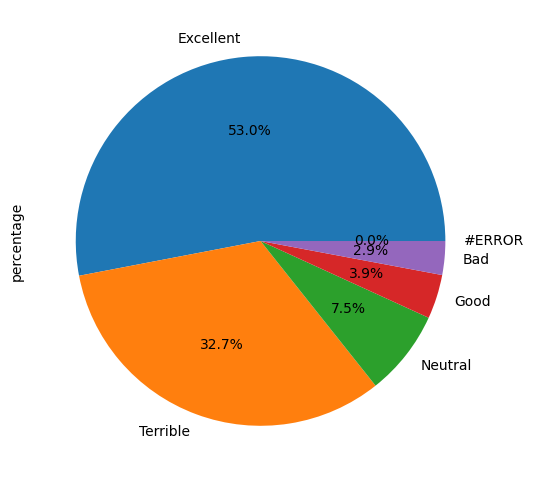

In [17]:
resumen['percentage'].plot.pie(autopct='%1.1f%%', figsize=(6, 6), labels=resumen.index)

In [18]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

<Axes: title={'center': 'Sentiment Analysis over time'}, xlabel='Date', ylabel='Score'>

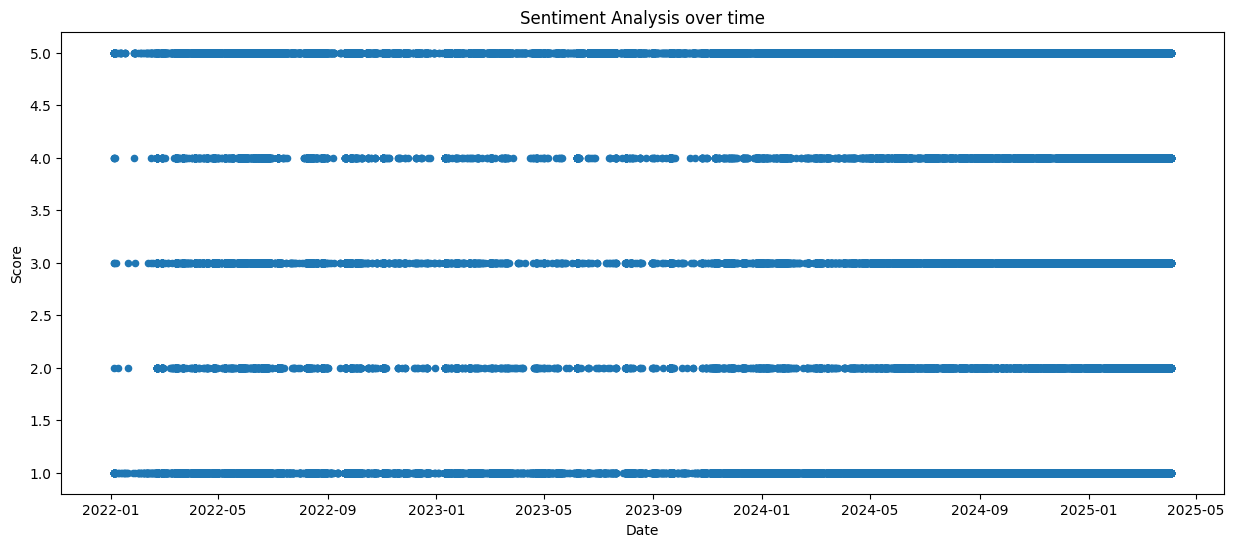

In [19]:
df_sentiment.sort_values(by='date').plot.scatter(x='date', y='score', figsize=(15, 6), title='Sentiment Analysis over time', xlabel='Date', ylabel='Score')

In [20]:
df_sentiment.to_excel(r"results\comments_sentiment_analysis_petro_v2.xlsx", index=False)

In [21]:
# df_sentiment = pd.read_excel(r"results\comments_sentiment_analysis_galan.xlsx")

In [22]:
# df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

In [11]:
df_sorted = df_sentiment.sort_values(by='date')

In [24]:
display(df_sorted.head(20))

,score,clasification,percentage,date,video_id
104813,5.0,Excellent,0.269834,2022-01-04 17:35:00,7049478498645298437
104715,5.0,Excellent,0.739452,2022-01-04 17:39:00,7049478498645298437
104950,1.0,Terrible,0.482716,2022-01-04 17:39:00,7049478498645298437
104775,5.0,Excellent,0.477536,2022-01-04 17:46:00,7049478498645298437
104722,5.0,Excellent,0.536816,2022-01-04 17:46:00,7049478498645298437
104778,5.0,Excellent,0.464001,2022-01-04 17:47:00,7049478498645298437
104758,5.0,Excellent,0.761399,2022-01-04 17:47:00,7049478498645298437
104855,5.0,Excellent,0.405291,2022-01-04 17:47:00,7049478498645298437
104837,5.0,Excellent,0.427028,2022-01-04 17:49:00,7049478498645298437
104708,1.0,Terrible,0.524823,2022-01-04 17:50:00,7049478498645298437


In [7]:
def count_ratings_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and rate, then count
    result = df.groupby(['month', 'score']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate Average
    temp_df = df[['month', 'score']].copy()

    # Group by month and calculate mean
    avg_ratings = temp_df.groupby('month')['score'].mean().round(2)

    result['average_rating'] = avg_ratings
    
    return result

In [12]:
monthly_counts = count_ratings_by_month(df_sorted)

In [ ]:
display(monthly_counts)

score,1.0,2.0,3.0,4.0,5.0,total,average_rating
month,,,,,,,
2022-01,47,3,5,5,74,134,3.42
2022-02,361,56,106,42,437,1002,3.14
2022-03,730,61,171,73,1234,2269,3.45
2022-04,1032,74,297,118,2439,3960,3.72
2022-05,1353,119,416,177,3236,5301,3.72
2022-06,1845,179,599,272,6055,8950,3.95
2022-07,749,207,244,97,600,1897,2.78
2022-08,919,181,358,189,2609,4256,3.80
2022-09,280,47,108,48,1215,1698,4.10


<Axes: title={'center': 'Total Ratings by Month'}, xlabel='Month', ylabel='Total Ratings'>

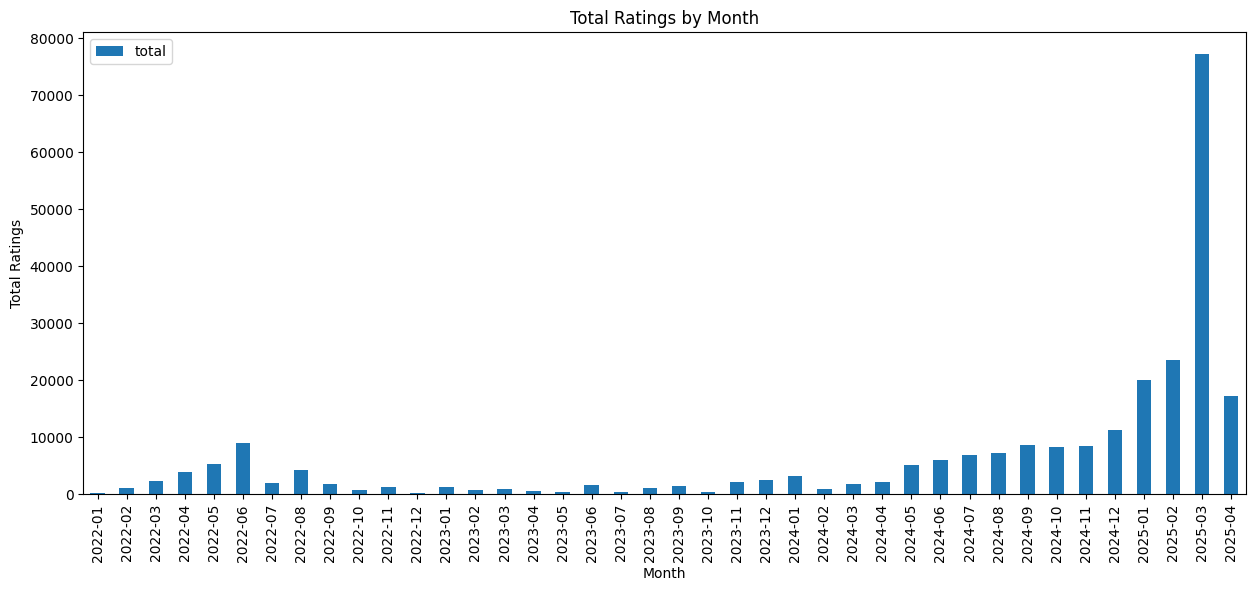

In [28]:
monthly_counts.plot.bar(y='total', figsize=(15, 6), title='Total Ratings by Month', xlabel='Month', ylabel='Total Ratings')

In [29]:

def visualize_rating_percentages(df):
    """
    Create visualizations for rating percentages by month and average rating over time.
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Calculate percentages for each rating
    for rating in range(1, 6):
        df_copy[f"{rating}_percent"] = (df_copy[rating] / df_copy['total'] * 100).round(2)
    
    # Get months from index
    months = df_copy.index
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Stacked bar chart - Rating distribution by month
    x = np.arange(len(months))
    width = 0.8
    
    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    
    # Colors for ratings
    colors = ['#FF9999', '#FFD699', '#FFFF99', '#99FF99', '#9999FF']
    
    # Create the stacked bar chart
    bottom = np.zeros(len(months))
    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        ax1.bar(x, data, width, bottom=bottom, label=label, color=colors[i])
        bottom += data
    
    ax1.set_title('Rating Distribution by Month', fontsize=14)
    ax1.set_ylabel('Percentage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(title='Rating')
    
    # 2. Line chart for average rating over time
    ax2.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC')
    
    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        ax2.text(i, val + 0.05, f"{val}", ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Rating by Month', fontsize=14)
    ax2.set_ylabel('Average Rating')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.set_ylim(min(df_copy['average_rating'])-0.5, max(df_copy['average_rating'])+0.5)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at rating 4.0 for reference
    ax2.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization - Heatmap of percentage distribution using imshow
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Prepare heatmap data
    heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(1, 6)])
    
    # Create heatmap using imshow
    im = ax.imshow(heatmap_data, cmap='YlGnBu')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Percentage (%)')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels([f"{i}★" for i in range(1, 6)])
    
    # Add text annotations to heatmap
    for i in range(5):
        for j in range(len(months)):
            text = ax.text(j, i, f"{heatmap_data[i, j]:.1f}%",
                          ha="center", va="center", color="black")
    
    plt.title('Percentage of Each Rating by Month', fontsize=14)
    plt.tight_layout()
    plt.show()

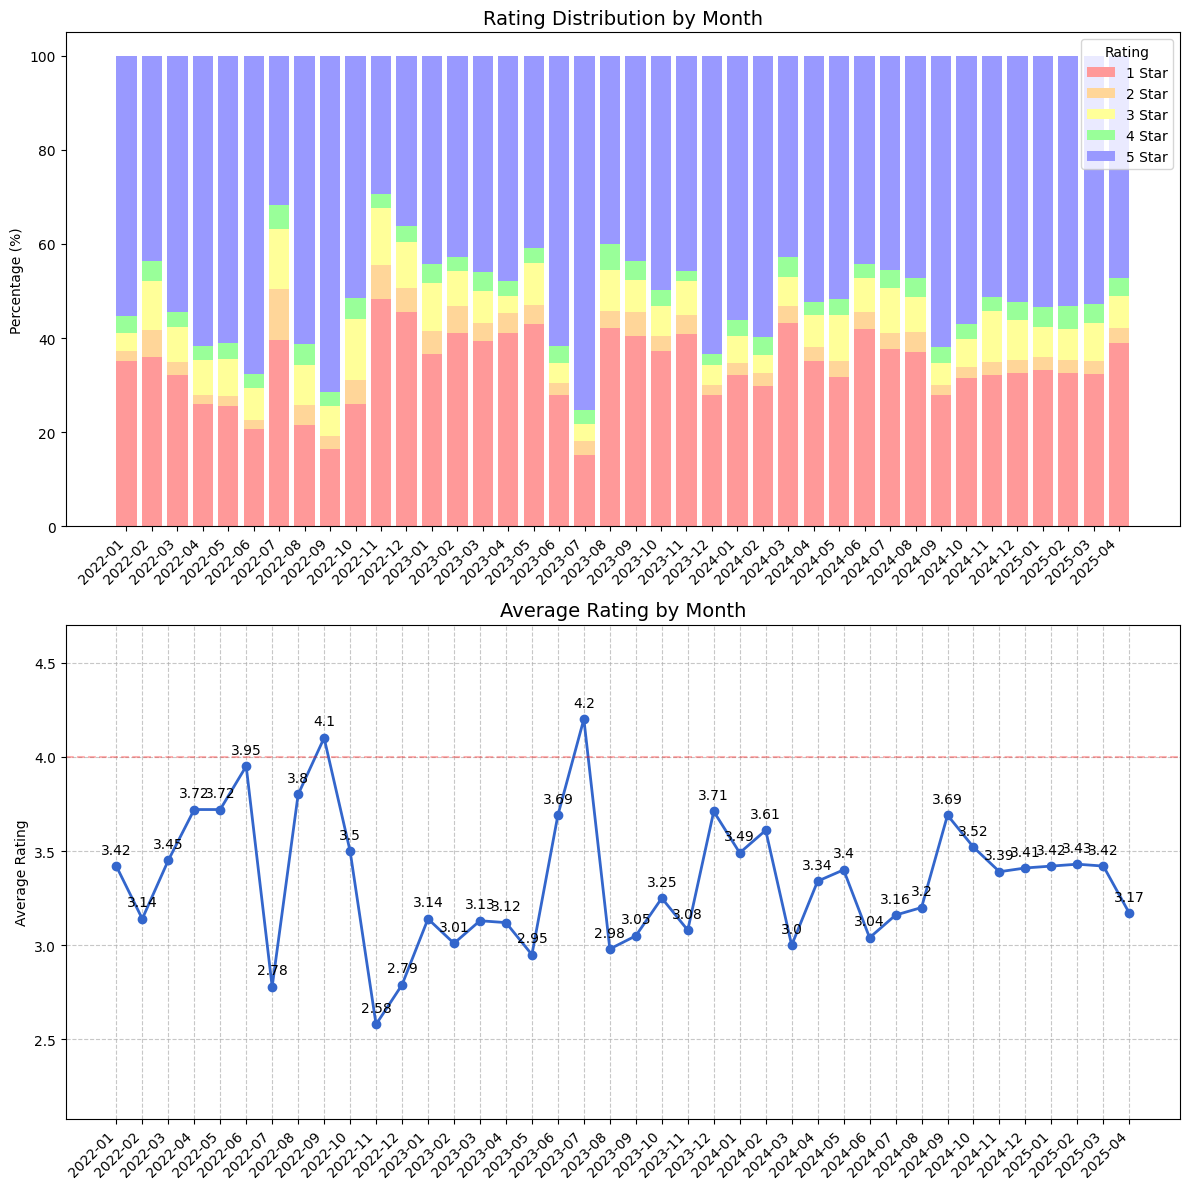

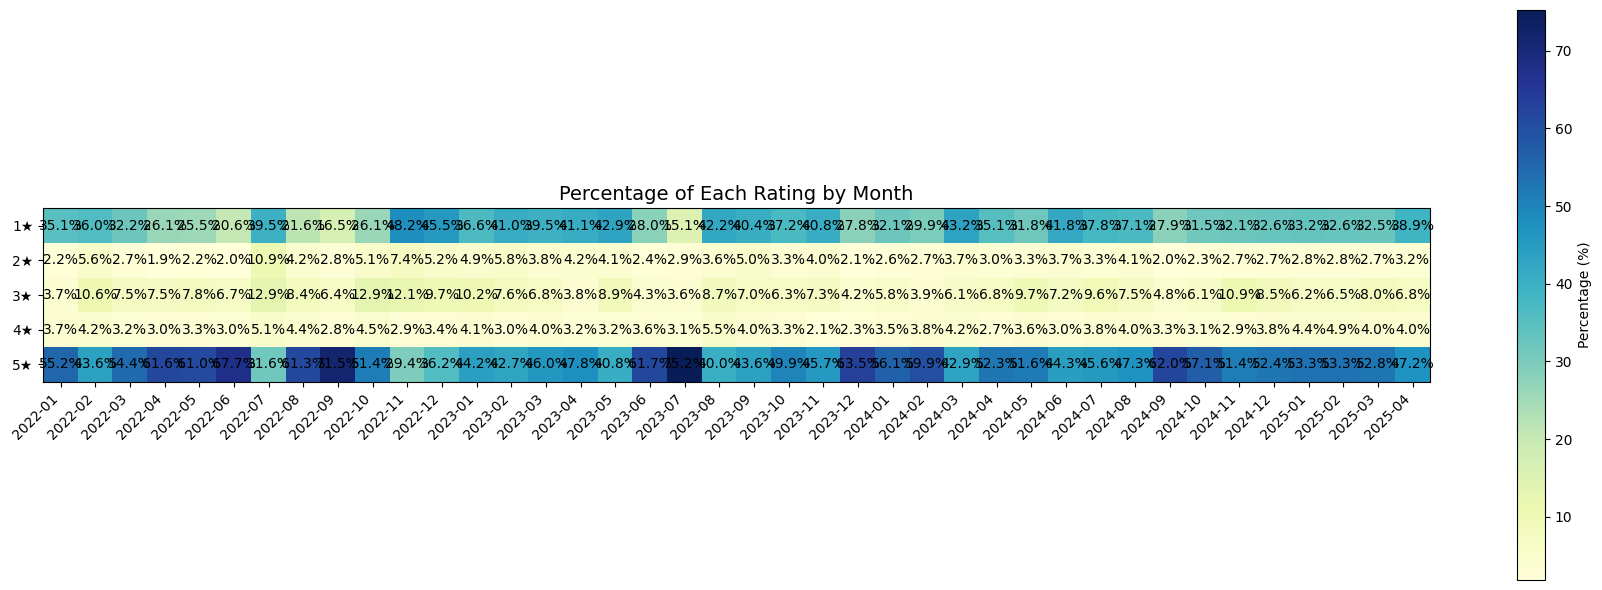

In [30]:
visualize_rating_percentages(monthly_counts)

In [7]:
df_sentiment['Approval'] = df_sentiment['score'].apply(lambda x: 'Approved' if x >= 4 else 'Disapproved' if x <= 2 else 'Neutral')

In [5]:
def approval_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and Approval status, then count
    result = df.groupby(['month', 'Approval']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate percentages
    for rating in ['Approved', 'Disapproved', 'Neutral']:
        result[f"{rating}_percent"] = (result[rating] / result['total'] * 100).round(2)

    # result['approval_percentages'] = approval_percentages
    
    return result

In [8]:
df_approval = approval_by_month(df_sentiment)

In [34]:
df_approval.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Approved', 'Disapproved', 'Neutral', 'total', 'Approved_percent',
       'Disapproved_percent', 'Neutral_percent'],
      dtype='object', name='Approval')>

In [35]:
display(df_approval.head(100))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent
month,,,,,,,
2022-01,79,50,5,134,58.96,37.31,3.73
2022-02,479,417,106,1002,47.80,41.62,10.58
2022-03,1307,791,171,2269,57.60,34.86,7.54
2022-04,2557,1106,297,3960,64.57,27.93,7.50
2022-05,3413,1472,416,5301,64.38,27.77,7.85
2022-06,6327,2024,599,8950,70.69,22.61,6.69
2022-07,697,956,244,1897,36.74,50.40,12.86
2022-08,2798,1100,358,4256,65.74,25.85,8.41
2022-09,1263,327,108,1698,74.38,19.26,6.36


In [44]:
polls_data = {
    'date': ['2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07','2023-08','2023-09','2023-10','2023-11','2023-12','2024-01','2024-02','2024-03','2024-04','2024-05','2024-06','2024-07','2024-08','2024-09','2024-10','2024-11','2024-12','2025-01','2025-02','2025-03'],
    'Approved_percent': [65.40, 61.95,48.67,55.21,51.97,45.83,43.08,40.16,36.15,35.01,32.59,36.78,34.36,33.19,30.09,32.78,32.13,33.01,34.83,31.47,32.88,32.00,30.43,31.94,30.34,30.27,33.67,32.72,31.89,35.63,37.04,34.29],
}
df_polls = pd.DataFrame(polls_data)

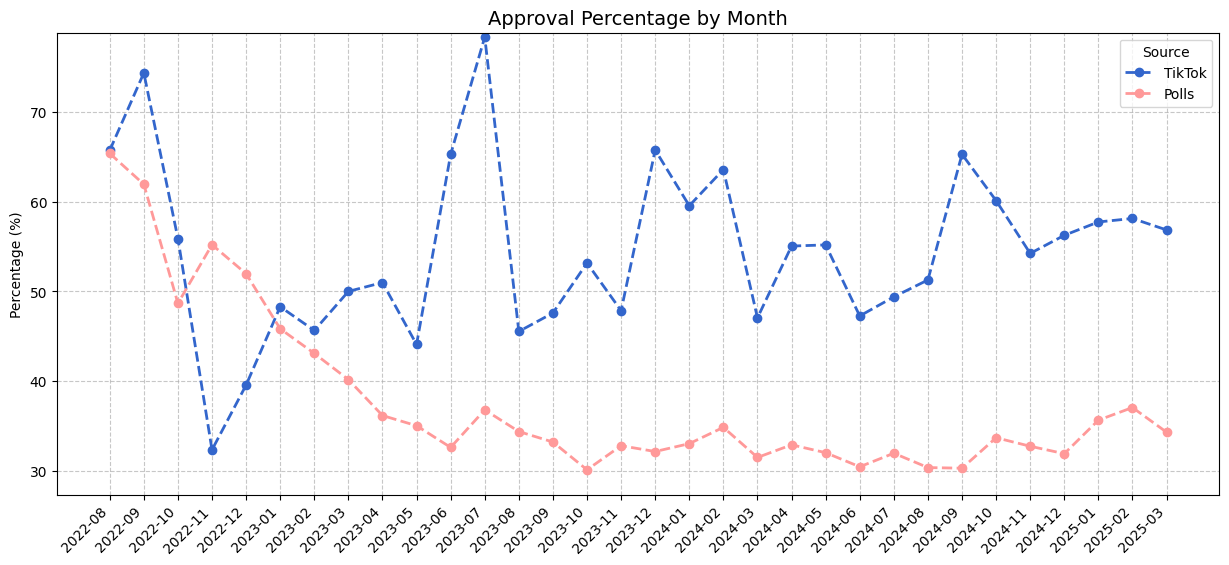

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

x_data = range(len(polls_data['date']))

ax1.set_title('Approval Percentage by Month', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(polls_data['date'], rotation=45, ha='right')
ax1.set_ylim(min(df_approval['Approved_percent'])-5, max(df_approval['Approved_percent'])+0.5)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.plot(x_data, df_approval.loc['2022-08':'2025-03']['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--')
ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.legend(['TikTok', 'Polls'], title='Source')


### Smooth curve

In [2]:
df_sentiment = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\results\comments_sentiment_analysis_petro_v2.xlsx", sheet_name='Sheet1')
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

In [24]:
display(df_sentiment.head(10))

,score,clasification,percentage,date,video_id,Approval,month
0,5.0,Excellent,0.518661,2024-09-24 21:22:00,7418389292159995144,Approved,2024-09
1,5.0,Excellent,0.422786,2024-09-24 20:46:00,7418389292159995144,Approved,2024-09
2,5.0,Excellent,0.642235,2025-02-05 18:29:00,7418389292159995144,Approved,2025-02
3,1.0,Terrible,0.646128,2024-09-25 06:30:00,7418389292159995144,Disapproved,2024-09
4,5.0,Excellent,0.575799,2024-09-24 22:02:00,7418389292159995144,Approved,2024-09
5,5.0,Excellent,0.584807,2024-09-25 06:44:00,7418389292159995144,Approved,2024-09
6,5.0,Excellent,0.669262,2024-09-24 20:45:00,7418389292159995144,Approved,2024-09
7,5.0,Excellent,0.812714,2024-09-24 20:48:00,7418389292159995144,Approved,2024-09
8,5.0,Excellent,0.942155,2024-11-15 08:00:00,7418389292159995144,Approved,2024-11
9,3.0,Neutral,0.253896,2024-09-24 20:53:00,7418389292159995144,Neutral,2024-09


In [22]:
display(monthly_counts.head(10))

score,1.0,2.0,3.0,4.0,5.0,total,average_rating
month,,,,,,,
2022-01,47,3,5,5,74,134,3.42
2022-02,361,56,106,42,437,1002,3.14
2022-03,730,61,171,73,1234,2269,3.45
2022-04,1032,74,297,118,2439,3960,3.72
2022-05,1353,119,416,177,3236,5301,3.72
2022-06,1845,179,599,272,6055,8950,3.95
2022-07,749,207,244,97,600,1897,2.78
2022-08,919,181,358,189,2609,4256,3.80
2022-09,280,47,108,48,1215,1698,4.10


In [25]:
df_approval['rolling_avg_aproval'] = df_approval['Approved_percent'].rolling(window=3, center=True).mean()

In [11]:
display(df_approval.head(10))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent
month,,,,,,,
2022-01,79,50,5,134,58.96,37.31,3.73
2022-02,479,417,106,1002,47.80,41.62,10.58
2022-03,1307,791,171,2269,57.60,34.86,7.54
2022-04,2557,1106,297,3960,64.57,27.93,7.50
2022-05,3413,1472,416,5301,64.38,27.77,7.85
2022-06,6327,2024,599,8950,70.69,22.61,6.69
2022-07,697,956,244,1897,36.74,50.40,12.86
2022-08,2798,1100,358,4256,65.74,25.85,8.41
2022-09,1263,327,108,1698,74.38,19.26,6.36


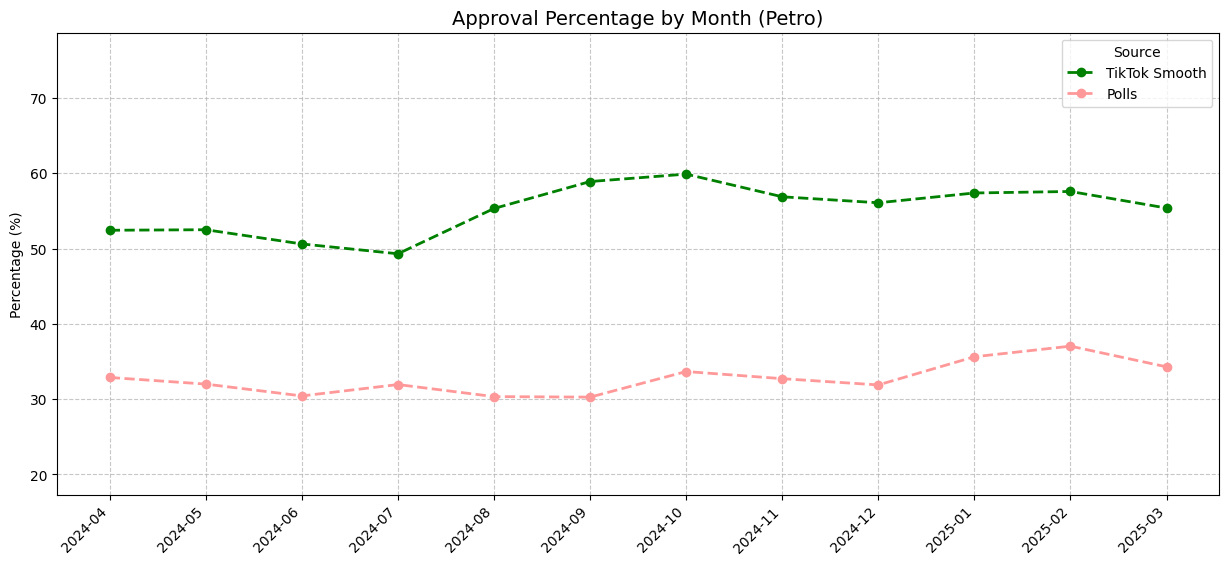

: 

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))


x_values = df_approval.loc['2024-04':'2025-03']['rolling_avg_aproval']
x_data = range(len(x_values))

ax1.set_title('Approval Percentage by Month (Petro)', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(polls_data['date'][-12:], rotation=45, ha='right')
ax1.set_ylim(min(df_approval['Approved_percent'])-15, max(df_approval['Approved_percent'])+0.3)
ax1.grid(True, linestyle='--', alpha=0.7)

# ax1.plot(x_data, df_approval.loc['2022-08':'2025-03']['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--')
# ax1.plot(x_data, df_approval.loc['2022-08':'2025-03']['rolling_avg_aproval'], marker='o', linewidth=2, color='green', linestyle='--')
# ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.plot(x_data, x_values, marker='o', linewidth=2, color='green', linestyle='--')
ax1.plot(x_data, df_polls.iloc[-12:]['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.legend(['TikTok Smooth','Polls'], title='Source')

### Stratified Sample

In [57]:
df_sentiment = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\results\comments_sentiment_analysis_petro_v2.xlsx", sheet_name='Sheet1')
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

In [24]:
def stratified_sample(dataframe, strata_column, sample_size_or_frac):
    """
    Perform stratified sampling on a dataframe
    
    Parameters:
    dataframe: pandas dataframe
    strata_column: column to stratify on
    sample_size_or_frac: can be a fraction (0 to 1) or dictionary with strata as keys
    
    Returns:
    Sampled dataframe
    """
    samples = []
    
    # Get unique strata
    strata = dataframe[strata_column].unique()
    
    for stratum in strata:
        stratum_df = dataframe[dataframe[strata_column] == stratum]
        
        # Determine sample size for this stratum
        if isinstance(sample_size_or_frac, dict):
            if stratum in sample_size_or_frac:
                size_or_frac = sample_size_or_frac[stratum]
            else:
                size_or_frac = 0.5  # default
        else:
            size_or_frac = sample_size_or_frac
            
        # Sample from this stratum
        if size_or_frac <= 1.0:
            # If fraction
            stratum_sample = stratum_df.sample(frac=size_or_frac, random_state=42)
        else:
            # If absolute size
            sample_size = min(size_or_frac, len(stratum_df))
            stratum_sample = stratum_df.sample(n=sample_size, random_state=42)
            
        samples.append(stratum_sample)
    
    # Combine samples from all strata
    return pd.concat(samples)

In [59]:
df_sentiment['year'] = df_sentiment['date'].dt.year
df_sentiment['month'] = df_sentiment['date'].dt.month

In [70]:
df_sentiment['Approval'] = df_sentiment['score'].apply(lambda x: 'Approved' if x >= 4 else 'Disapproved' if x <= 2 else 'Neutral')

In [128]:
sample_sizes = {2022: 0, 2023: 0, 2024: 0.2, 2025: 0.1}
df_sampled = stratified_sample(df_sentiment, 'year', sample_sizes)

In [129]:
len(df_sentiment.index)

251971

In [130]:
len(df_sampled.index)

27626

In [131]:
df_sampled = df_sampled.sort_values(by='date')

In [132]:
display(df_sampled.head(10))

,score,clasification,percentage,date,video_id,year,month,Approval
14512,5.0,Excellent,0.575458,2024-01-01 00:21:00,7316354960734637318,2024.0,2024-01,Approved
110122,5.0,Excellent,0.513234,2024-01-01 00:22:00,7299679895444049158,2024.0,2024-01,Approved
14509,5.0,Excellent,0.803884,2024-01-01 01:12:00,7316354960734637318,2024.0,2024-01,Approved
15109,5.0,Excellent,0.514025,2024-01-01 01:13:00,7316354960734637318,2024.0,2024-01,Approved
180670,1.0,Terrible,0.296137,2024-01-01 01:20:00,7310443171559804166,2024.0,2024-01,Disapproved
14508,3.0,Neutral,0.280614,2024-01-01 01:30:00,7316354960734637318,2024.0,2024-01,Neutral
52615,4.0,Good,0.261532,2024-01-01 01:40:00,7318618492444413189,2024.0,2024-01,Approved
52816,5.0,Excellent,0.768682,2024-01-01 03:32:00,7318618492444413189,2024.0,2024-01,Approved
14507,3.0,Neutral,0.356940,2024-01-01 03:55:00,7316354960734637318,2024.0,2024-01,Neutral
14506,5.0,Excellent,0.784615,2024-01-01 07:19:00,7316354960734637318,2024.0,2024-01,Approved


In [133]:
df_approval_sampled = approval_by_month(df_sampled)

In [134]:
df_approval = approval_by_month(df_sentiment)

In [135]:
display(df_approval_sampled.head(10))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent
month,,,,,,,
2024-01,390,214,37,641,60.84,33.39,5.77
2024-02,91,46,4,141,64.54,32.62,2.84
2024-03,156,166,19,341,45.75,48.68,5.57
2024-04,235,160,33,428,54.91,37.38,7.71
2024-05,541,367,94,1002,53.99,36.63,9.38
2024-06,529,547,95,1171,45.18,46.71,8.11
2024-07,698,574,131,1403,49.75,40.91,9.34
2024-08,740,618,122,1480,50.00,41.76,8.24
2024-09,1123,506,81,1710,65.67,29.59,4.74


<Axes: title={'center': 'Total Ratings by Month'}, xlabel='Month', ylabel='Total Ratings'>

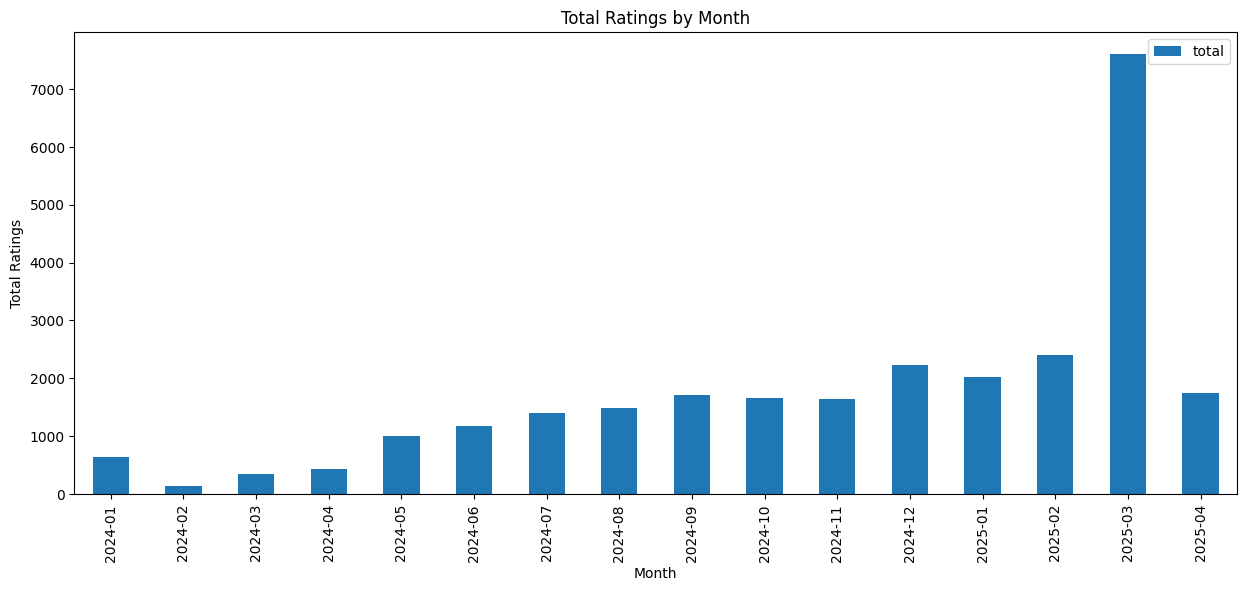

In [136]:
df_approval_sampled.plot.bar(y='total', figsize=(15, 6), title='Total Ratings by Month', xlabel='Month', ylabel='Total Ratings')

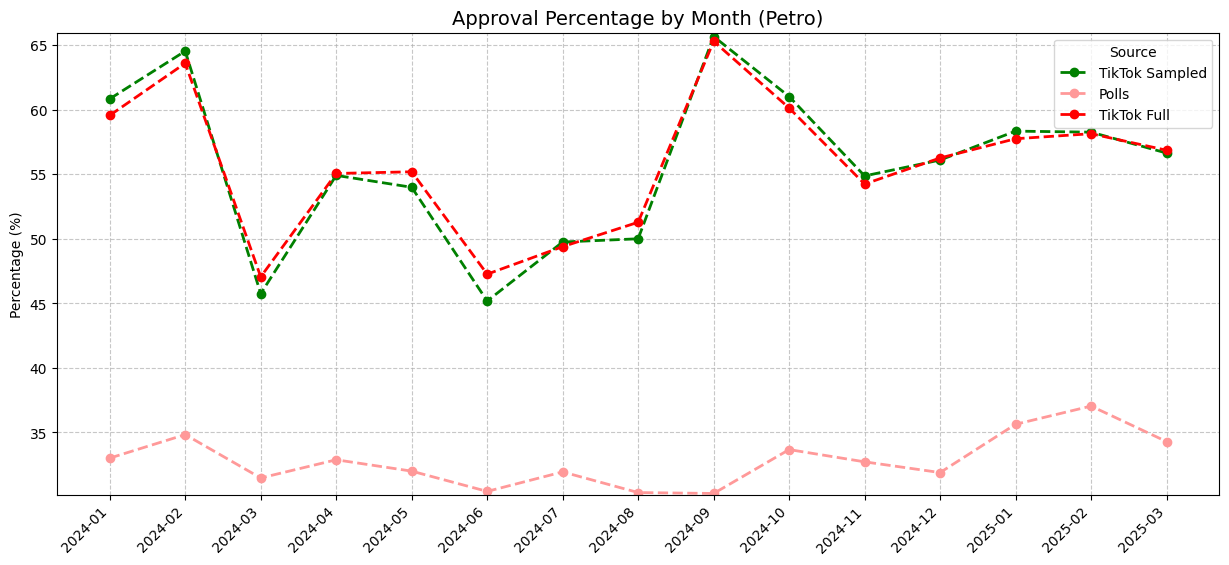

In [137]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))


x_values = df_approval_sampled.loc['2024-01':'2025-03']['Approved_percent']
x_data = range(len(x_values))

ax1.set_title('Approval Percentage by Month (Petro)', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(df_approval_sampled.loc['2024-01':'2025-03'].index, rotation=45, ha='right')
# ax1.set_xticklabels(polls_data['date'][-12:], rotation=45, ha='right')
ax1.set_ylim(min(df_approval_sampled['Approved_percent'])-15, max(df_approval_sampled['Approved_percent'])+0.3)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.plot(x_data, x_values, marker='o', linewidth=2, color='green', linestyle='--')
ax1.plot(x_data, df_polls.iloc[-15:]['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')
# ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')
ax1.plot(x_data, df_approval.loc['2024-01':'2025-03']['Approved_percent'], marker='o', linewidth=2, color='red', linestyle='--')

ax1.legend(['TikTok Sampled','Polls', 'TikTok Full'], title='Source')